In [ ]:
!pip install keras_tuner
import numpy as np
import tensorflow as tf
from tensorflow import keras
import re
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Progbar
import keras_tuner
import pandas as pd

# **Preprocessing the Data**

In [ ]:
df=pd.read_csv("/content/english_to_telugu.csv")

def decontractions(phrase):
    #specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

df['english']=df['english'].apply(decontractions)
df['english']=df['english'].apply(lambda x : re.sub('[^A-Za-z1-9]|\'|\"',' ',x))
english=" ".join(df['english'].values)
english_words=set(english.split()) #10227 unique words


df['telugu']=df['telugu'].apply(lambda x : re.sub('\?|\.|\'|\"',' ',x))
telugu=" ".join(df['telugu'].values)
telugu_words=set(telugu.split()) #16499  unique words


english_vocab = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(df['english'], target_vocab_size=2**13)
telugu_vocab = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(df['telugu'], target_vocab_size=2**13)

#telugu_vocab_size=2768
#english_vocab_size=8566
'''
for english
count    10205.000000
mean        14.888192
std          8.591652
min          1.000000
25%         10.000000
50%         13.000000
75%         18.000000
max        173.000000
for telugu
count    10205.000000
mean        56.355414
std         29.836997
min          2.000000
25%         37.000000
50%         52.000000
75%         69.000000
max        374.000000
'''

In [ ]:
eng_v=english_vocab.vocab_size
tel_v=telugu_vocab.vocab_size

def encode(e, t):
    eng=[eng_v]+english_vocab.encode(e.numpy())+[eng_v+1]
    tel=[tel_v]+telugu_vocab.encode(t.numpy())+[tel_v+1]
    return eng, tel

def tf_encode(e, t):
    result_e, result_t = tf.py_function(encode, [e, t], [tf.int64, tf.int64])
    result_e.set_shape([None])
    result_t.set_shape([None])
    return result_e, result_t

In [ ]:

train, validation = train_test_split(df, test_size=0.2, random_state=20)
train_dataset = tf.data.Dataset.from_tensor_slices(dict(train))
train_dataset = train_dataset.map(lambda x: tf_encode(x['english'], x['telugu']))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(1000).padded_batch(32, padded_shapes=([None],[None]))
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
"""
def padding_mask(seq):  #seq-->(batch_size,seq_len)
    seq=tf.cast(tf.math.equal(seq,0),dtype=float)
    return seq[:,np.newaxis,np.newaxis,:]  #seq-->(batch_size,1,1,seq) for broadcasting

def look_ahead_mask(seq_len):   #seq_len-->length of context window of transformer
    mask=1-tf.linalg.band_part(tf.ones((seq_len,seq_len)),-1,0) #(seq_len,seq_len)
    return mask
"""

# **Transformer Architecture**


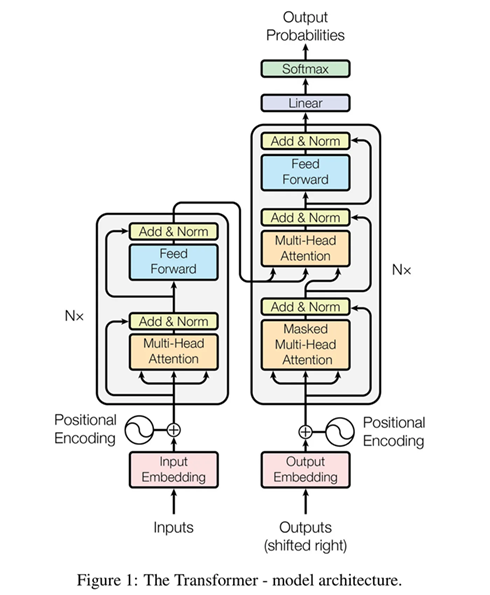

In [ ]:
#def positional_encoding(d_model: int,seq_len: int):




  #  return pos_encoding


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    """
    position: padded sentence length (5)
    d_model: embedding vector length (100)
    """
    # reshaping before passing into function : 5->(5,1), 100->(1,100) this will be helpful in getting 5X100 position matrix
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2]) #for even positions using sin()
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2]) #for odd positions using cos()
    pos_encoding = angle_rads[np.newaxis,:]
    return tf.cast(pos_encoding, dtype=tf.float32)

# **Multihead Attention**


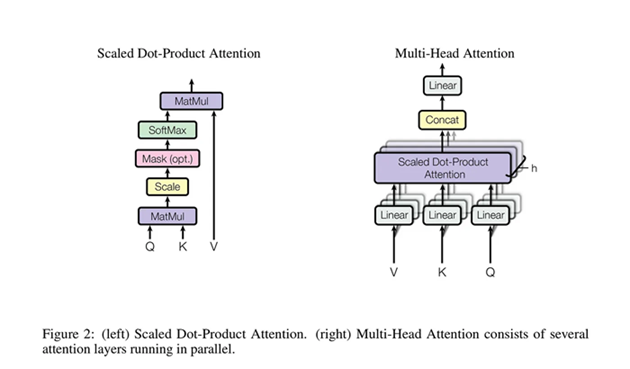


# **Attention matrix is calculated using the following formula**


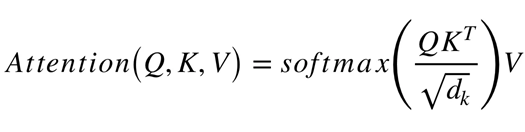

In [ ]:
def scaled_dotproduct_attention(q,k,v,mask=None):
    #print("scaled")
    #q,k,v---->(batch_size,heads,seq_len,depth)
    matmul_qk=tf.matmul(q,k,transpose_b=True) #(batch_size,heads,seq_len,seq_len)

    dk=np.sqrt(k.shape[-1])
    scaled_attention_logits=matmul_qk/dk
    if mask is not None:
       scaled_attention_logits += mask*-1e9

    attention_weights=tf.nn.softmax(scaled_attention_logits,axis=-1)
    attention=tf.matmul(attention_weights,v) #(batch_size,heads,seq_len,depth)

    return attention,attention_weights


class MultiHeadAttention(tf.keras.layers.Layer):

       def __init__(self,d_model,no_heads):
           super().__init__()
           #print("MHA")
           self.d_model=d_model
           self.no_heads=no_heads
           self.depth=d_model//self.no_heads
           self.wq=tf.keras.layers.Dense(d_model)
           self.wk=tf.keras.layers.Dense(d_model)
           self.wv=tf.keras.layers.Dense(d_model)
           self.wo=tf.keras.layers.Dense(d_model)  #linear activation functions
       def split_heads(self,x):
           batch_size=tf.shape(x)[0]
           x=tf.reshape(x,(batch_size,-1,self.no_heads,self.depth))
           return tf.transpose(x,perm=[0,2,1,3])

       def call(self,q,k,v,mask):
           #q,k,v---->(batch,seq_len,d_model)
           q=self.wq(q)
           k=self.wk(k)
           v=self.wv(v) #q,k,v--->(batch,seq_len,d_model)

           q=self.split_heads(q)
           k=self.split_heads(k)
           v=self.split_heads(v)    #q,k,v--->(batch,no_heads,seq_len,depth)
           attention,attention_weights=scaled_dotproduct_attention(q,k,v,mask)
           # attention.shape=(b,h,s,depth) attention_weights=(b,h,s,s)

           attention=tf.transpose(attention,perm=[0,2,1,3])    #(b,s,h,depth)
           #attention_weights=tf.transpose(attention_weights,perm=[0,2,1,3])
           s=tf.shape(attention)
           concatenate_attention=tf.reshape(attention,(s[0],s[1],s[2]*s[3]))#(b,s,d_model)
           output=self.wo(concatenate_attention)    #(b,s,d_model)
           return output,attention_weights





# **Encoder**

In [ ]:
def feed_forward_layer(d_model,dff):
     return tf.keras.Sequential([
         tf.keras.layers.Dense(dff,activation='relu'),
         tf.keras.layers.Dense(d_model)]
     )

class EncodeLayer(tf.keras.layers.Layer):

      def __init__(self,d_model,heads,dff,rate):
          super().__init__()
          #print("encoder_layer")
          self.mha = MultiHeadAttention(d_model, heads)
          self.dropout1 = tf.keras.layers.Dropout(rate)
          self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
          self.ffn = feed_forward_layer(d_model, dff)
          self.dropout2 = tf.keras.layers.Dropout(rate)
          self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)


      def call(self,x,training,enc_padding_mask):
          output,_=self.mha(x,x,x,enc_padding_mask)
          output=self.dropout1(output,training=training)
          ffn_input=self.layernorm1(x+output)

          ffn_out=self.ffn(ffn_input)
          ffn_output=self.dropout2(ffn_out,training=training)
          dec_output=self.layernorm2(ffn_input+ffn_output)
          return dec_output



In [ ]:
class Encoder(tf.keras.layers.Layer):

      def __init__(self,d_model,max_seqlen,enc_vocab_size,num_layers,heads,dff,rate):
          super().__init__()
          #print("encoder")
          self.d_model=d_model
          self.num_layers=num_layers
          self.embedding=tf.keras.layers.Embedding(enc_vocab_size,d_model)
          self.pos_encoding=positional_encoding(d_model,max_seqlen)
          self.encode_layers=[EncodeLayer(d_model,heads,dff,rate) for n in range(self.num_layers)]
          #self.dropout = tf.keras.layers.Dropout(rate)
          #print("enc_o")

      def call(self,input,training,enc_padding_mask):
          #print("call encoder")

          emb_inp=self.embedding(input) #(b,s,d_m)
          emb_inp *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
          seq_l=tf.shape(emb_inp)[1]
          emb_pos=emb_inp+self.pos_encoding[:,:seq_l,:]
           #x = self.dropout(x, training=training)
          x=emb_pos
          for i in range(self.num_layers):
              x=self.encode_layers[i](x,training,enc_padding_mask)

          return x



# **Decoder**

In [ ]:
class Decoderlayer(tf.keras.layers.Layer):

      def __init__(self,d_model,heads,dff,rate):
          super().__init__()
          #print("decoder_layer")
          self.mha1=MultiHeadAttention(d_model,heads)
          self.dropout1=tf.keras.layers.Dropout(rate)
          self.lay_norm1=tf.keras.layers.LayerNormalization(epsilon=1e-6)

          self.mha2=MultiHeadAttention(d_model,heads)
          self.dropout2=tf.keras.layers.Dropout(rate)
          self.lay_norm2=tf.keras.layers.LayerNormalization(epsilon=1e-6)

          self.ffn=feed_forward_layer(d_model,dff)
          self.lay_norm3=tf.keras.layers.LayerNormalization(epsilon=1e-6)
          self.dropout3=tf.keras.layers.Dropout(rate)

      def call(self,x,training,enc_out,look_ahead_mask,memory_mask):

          dec_att,_=self.mha1(x,x,x,look_ahead_mask)
          dec_att=self.dropout1(dec_att,training=training)
          q_norm=self.lay_norm1(dec_att+x)

          mha2_out,_=self.mha2(q_norm,enc_out,enc_out,memory_mask)
          mha2_out=self.dropout2(mha2_out)
          ffn_in=self.lay_norm2(mha2_out+q_norm)

          ffn_out=self.ffn(ffn_in)
          ffn_out=self.dropout3(ffn_out,training=training)
          dec_out=self.lay_norm3(ffn_out+ffn_in)

          return dec_out



In [ ]:
class Decoder(tf.keras.layers.Layer):

      def __init__(self,d_model,max_seqlen,dec_vocab_size,num_layers,heads,dff,rate):
          super().__init__()
          #print("decoder")
          self.d_model=d_model
          self.num_layers=num_layers
          self.embedding=tf.keras.layers.Embedding(dec_vocab_size,d_model)
          self.pos_enc=positional_encoding(d_model,max_seqlen)
          self.dec_layers=[Decoderlayer(d_model,heads,dff,rate) for n in range(num_layers)]
          self.dropout=tf.keras.layers.Dropout(rate)

      def call(self,input,enc_out,training,look_ahead_mask,memory_mask):

          input=self.embedding(input)
          seq_len=tf.shape(input)[1]
          input+=self.pos_enc[:,:seq_len,:]
          x=input
          for i in range(self.num_layers):
              x=self.dec_layers[i](x,training,enc_out,look_ahead_mask,memory_mask)

          return x


# **Transformer combining Encoder and Decoder**

In [ ]:
class Transformer(tf.keras.Model):

      def __init__(self,max_seqlen,d_model,enc_vocab_size,dec_vocab_size,heads,dff,rate,enc_lay,dec_lay):

          super().__init__()
          #print("trans")
          self.enc=Encoder(d_model,max_seqlen,enc_vocab_size,enc_lay,heads,dff,rate)

          self.dec=Decoder(d_model,max_seqlen,dec_vocab_size,dec_lay,heads,dff,rate)

          self.final_layer=tf.keras.layers.Dense(dec_vocab_size)

      def call(self,input,target,training,enc_padding_mask=None,look_ahead_mask=None,memory_mask=None):

          enc_out=self.enc(input,training,enc_padding_mask)

          dec_outout=self.dec(target,enc_out,training,look_ahead_mask,memory_mask)

          word_logits=self.final_layer(dec_outout)


          return word_logits




In [ ]:
def padding_mask(seq):  #seq-->(batch_size,seq_len)
    seq=tf.cast(tf.math.equal(seq,0),dtype=float)
    return seq[:,np.newaxis,np.newaxis,:]  #seq-->(batch_size,1,1,seq) for broadcasting

def look_ahead_mask(seq_len):   #seq_len-->length of context window of transformer
    mask=1-tf.linalg.band_part(tf.ones((seq_len,seq_len)),-1,0) #(seq_len,seq_len)
    return mask


def create_mask(input,target):
    #input,target--->(batchsize,seq_len)
    enc_mask=padding_mask(input)
    dec_mask=enc_mask
    dec_input=padding_mask(target)
    look_ahead=look_ahead_mask(tf.shape(target)[1])
    combined_mask=tf.maximum(dec_input,look_ahead)

    return enc_mask, combined_mask, dec_mask


In [ ]:
"""
optimizer=keras.optimizers.Adam(0.001)
accuracy=keras.metrics.SparseCategoricalAccuracy()
loss_mean=keras.metrics.Mean()

def loss_fn(y_true,y_pred):
    #y_true-->(64,512)
    #y_pred--->(64,512,2768)
    sparse_loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')
    l=sparse_loss(y_true,y_pred)
    loss_weight=tf.cast(tf.math.not_equal(l,0),float)
    l=l*loss_weight
    l=tf.reduce_sum(l)/tf.reduce_sum(loss_weight)
    return l


train_step_signature = [
  tf.TensorSpec(shape=(None, None), dtype=tf.int64),
  tf.TensorSpec(shape=(None, None), dtype=tf.int64) ]

@tf.function(input_signature=train_step_signature)
def train_step(x,y):
    # x,y--->(64,512)
     tar_inp=y[:,:-1]
     tar_out=y[:,1:]

     enc,look_ahead,dec=create_mask(x,tar_inp)

     with tf.GradientTape() as tape:

           dec_logits=translator(x,tar_inp,True,enc,look_ahead,dec)
           loss=loss_fn(tar_out,dec_logits)
     loss_mean.update_state(loss)
     accuracy.update_state(tar_out,dec_logits)
     gradients=tape.gradient(loss,translator.trainable_variables)
     optimizer.apply_gradients(zip(gradients,translator.trainable_variables))


for epoch in range(epochs):
    print("\nepoch {}/{}".format(epoch+1,epochs))
    pb_i = Progbar(train.shape[0],stateful_metrics=["loss","acc"])
    for (batch,(x,y)) in enumerate(train_dataset):

        train_step(x,y)
        values=[('loss',loss_mean.result()), ('acc',accuracy.result())]
        pb_i.add(32, values=values)
              #if(batch>10):
                #break

"""


# **HYPERPARAMETER TUNING**

In [ ]:
# fixed:max_seqlen=512,telugu_vocab_size=2770,english_vocab_size=8568,heads=8
# variable:d_model,dff,rate,enc_lay,dec_lay

class HyperTranslator(keras_tuner.HyperModel):

      def build(self,hp):
          max_seqlen=512
          telugu_vocab_size=2770
          english_vocab_size=8568
          heads=8
          d_model=hp.Choice("d_model",[128,256])
          dff=hp.Int("dff",128,256,step=128)
          rate=hp.Float("rate",0.1,0.2,step=0.05)
          enc_lay=hp.Int("enc_lay",2,6,step=1)
          dec_lay=enc_lay
          model=Transformer(max_seqlen,d_model,english_vocab_size,telugu_vocab_size,heads,dff,rate,enc_lay,dec_lay)

          return model

      def fit(self,hp,model,epochs,callbacks=None):

          optimizer=keras.optimizers.Adam(0.001)
          accuracy=keras.metrics.SparseCategoricalAccuracy()
          loss_mean=keras.metrics.Mean()

          def loss_fn(y_true,y_pred):
              #y_true-->(64,512)
              #y_pred--->(64,512,2768)
              sparse_loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')
              l=sparse_loss(y_true,y_pred)
              loss_weight=tf.cast(tf.math.not_equal(l,0),float)
              l=l*loss_weight
              l=tf.reduce_sum(l)/tf.reduce_sum(loss_weight)
              return l

          train_step_signature = [
          tf.TensorSpec(shape=(None, None), dtype=tf.int64),
          tf.TensorSpec(shape=(None, None), dtype=tf.int64) ]

          @tf.function(input_signature=train_step_signature)
          def train_step(x,y):
              # x,y--->(64,512)
              tar_inp=y[:,:-1]
              tar_out=y[:,1:]

              enc,look_ahead,dec=create_mask(x,tar_inp)

              with tf.GradientTape() as tape:

                    dec_logits=model(x,tar_inp,True,enc,look_ahead,dec)
                    loss=loss_fn(tar_out,dec_logits)
              loss_mean.update_state(loss)
              accuracy.update_state(tar_out,dec_logits)
              gradients=tape.gradient(loss,model.trainable_variables)
              optimizer.apply_gradients(zip(gradients,model.trainable_variables))
          acc=0
          for epoch in range(epochs):
              accuracy.reset_states()
              loss_mean.reset_states()

              for (batch,(x,y)) in enumerate(train_dataset):
                  train_step(x,y)

              acc=max(acc,float(accuracy.result().numpy()))


          return acc


tuner=keras_tuner.RandomSearch(
    hypermodel=HyperTranslator(),
    objective=keras_tuner.Objective(name="default_objective", direction="max"),
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="results",
    project_name="translator")

tuner.search(1)


Trial 3 Complete [00h 04m 32s]
default_objective: 0.6298954486846924

Best default_objective So Far: 0.6298954486846924
Total elapsed time: 00h 08m 44s


In [ ]:
tuner.results_summary()

Results summary
Results in results/translator
Showing 10 best trials
Objective(name="default_objective", direction="max")

Trial 2 summary
Hyperparameters:
d_model: 128
dff: 128
rate: 0.1
enc_lay: 2
Score: 0.6298954486846924

Trial 0 summary
Hyperparameters:
d_model: 128
dff: 128
rate: 0.1
enc_lay: 3
Score: 0.6173874139785767

Trial 1 summary
Hyperparameters:
d_model: 128
dff: 256
rate: 0.2
enc_lay: 4
Score: 0.6080553233623505


**Trail 1 has more accuracy with smaller size of each parameter**

**Therefore choosing trail 1 for further training with more number of epochs**


In [ ]:
def fit(model,epochs):

    optimizer=keras.optimizers.Adam(0.001)
    accuracy=keras.metrics.SparseCategoricalAccuracy()
    loss_mean=keras.metrics.Mean()
    #accuracy.reset_states()
    #loss_mean.reset_states()

    def loss_fn(y_true,y_pred):
        #y_true-->(64,512)
        #y_pred--->(64,512,2768)
        sparse_loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')
        l=sparse_loss(y_true,y_pred)
        loss_weight=tf.cast(tf.math.not_equal(l,0),float)
        l=l*loss_weight
        l=tf.reduce_sum(l)/tf.reduce_sum(loss_weight)
        return l

    train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64) ]

    @tf.function(input_signature=train_step_signature)
    def train_step(x,y):
        # x,y--->(64,512)
        tar_inp=y[:,:-1]
        tar_out=y[:,1:]

        enc,look_ahead,dec=create_mask(x,tar_inp)

        with tf.GradientTape() as tape:

              dec_logits=model(x,tar_inp,True,enc,look_ahead,dec)
              loss=loss_fn(tar_out,dec_logits)
        loss_mean.update_state(loss)
        accuracy.update_state(tar_out,dec_logits)
        gradients=tape.gradient(loss,model.trainable_variables)
        optimizer.apply_gradients(zip(gradients,model.trainable_variables))

    for epoch in range(epochs):
         accuracy.reset_states()
         loss_mean.reset_states()
         print("\nepoch {}/{}".format(epoch+1,epochs))
         pb_i = Progbar(train.shape[0],stateful_metrics=["loss","acc"])
         for (batch,(x,y)) in enumerate(train_dataset):
             train_step(x,y)
             values=[('loss',loss_mean.result()), ('acc',accuracy.result())]
             pb_i.add(32, values=values)


In [ ]:
#WITH TRAIL 2 HYPERPARAMETERS
#telugu_vocab_size=2768
#english_vocab_size=8566

max_seqlen=512
d_model=128
telugu_vocab_size=2770
english_vocab_size=8568
heads=8
dff=128
rate=0.1
enc_lay=2
dec_lay=2

translator=Transformer(max_seqlen,d_model,english_vocab_size,telugu_vocab_size,heads,dff,rate,enc_lay,dec_lay)


In [ ]:
fit(translator,2)

In [ ]:
translator.summary() #2.69 billion paramerters

Model: "transformer_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  1295872   
                                                                 
 decoder_1 (Decoder)         multiple                  686336    
                                                                 
 dense_65 (Dense)            multiple                  357330    
                                                                 
Total params: 2339538 (8.92 MB)
Trainable params: 2339538 (8.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#tel_vocab=2768
#eng_vocab=8566

def translate(input):

    telugu_vocab_size=telugu_vocab.vocab_size
    english_vocab_size=english_vocab.vocab_size

    input_sen=[english_vocab_size]+english_vocab.encode(input)+[english_vocab_size+1]
    input_sen=tf.expand_dims(input_sen,0)
    dec_inp=[telugu_vocab_size]
    dec_inp=tf.expand_dims(dec_inp,0)

    for i in range(200):

         enc,com,dec=create_mask(input_sen,dec_inp)
         logits=translator(input_sen,dec_inp,False,enc,com,dec)
         prob_words=logits[:,-1:,:]
         pred_words=tf.cast(tf.argmax(prob_words,axis=-1),tf.int32)
         pred_wordid=pred_words
         if(pred_wordid==telugu_vocab_size+1):
            print("end token")
            break

         dec_inp=tf.concat([dec_inp,pred_wordid],axis=-1)

    dec_inp=tf.squeeze(dec_inp,axis=0)
    dec_string=telugu_vocab.decode([ i for i in dec_inp if i <telugu_vocab_size])

    return dec_string


In [ ]:
translate("how are you")

end token


'మా ఎల్లాదా '

In [ ]:
a=3256
print(df[a:a+1]['english'].values[0])
print(df[a:a+1]['telugu'].values[0])

She gasped in surprise when she saw a shooting star streak across the sky 
ఆమె ఆకాశంలో షూటింగ్ స్టార్ స్ట్రీక్ చూసినప్పుడు ఆమె ఆశ్చర్యానికి గురిచేసింది 
